# Fase 4 · Resultados y Análisis
**Fecha:** 2025-10-25 19:06

- Resumen de *GridSearchCV* para **Regresión** y **Clasificación**
- Métricas finales en test
- Gráficos comparativos
- Matriz de confusión
- Conclusiones rápidas



In [1]:
import sys, os, platform, matplotlib as mpl
print("Python:", sys.version)
print("Exe:", sys.executable)
print("Backend MPL:", mpl.get_backend())
print("CWD:", os.getcwd())

# Evita backends problemáticos
%matplotlib inline


Python: 3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
Exe: c:\Users\gabri\OneDrive\Escritorio\proyecto-ml-Gabriel-Hinostroza-Pedro-Barrientos-main\.venv\Scripts\python.exe
Backend MPL: module://matplotlib_inline.backend_inline
CWD: c:\Users\gabri\OneDrive\Escritorio\proyecto-ml-Gabriel-Hinostroza-Pedro-Barrientos-main\notebooks


In [ ]:

import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Detecta automáticamente dónde está la carpeta data/08_reporting
CWD = Path.cwd()
candidates = [
    CWD / "data/08_reporting",        
    CWD.parent / "data/08_reporting", 
    CWD.parents[1] / "data/08_reporting",
]
REP_PATH = next((p for p in candidates if p.exists()), None)
assert REP_PATH is not None, "No se encontró la carpeta data/08_reporting en rutas relativas conocidas."
REP = str(REP_PATH)

print("Usando REP =", REP)

paths = {
    "reg_cv_summary": f"{REP}/reg_cv_summary.csv",
    "reg_metrics":    f"{REP}/reg_metrics.json",
    "clf_cv_summary": f"{REP}/clf_cv_summary.csv",
    "clf_metrics":    f"{REP}/clf_metrics.json",
    "clf_conf":       f"{REP}/clf_confusion_matrix.json",
}

missing = [p for p in paths.values() if not os.path.exists(p)]
print("Archivos faltantes:" if missing else "Todos los artefactos están presentes ✅")
for p in missing: print(" -", p)


Usando REP = c:\Users\gabri\OneDrive\Escritorio\proyecto-ml-Gabriel-Hinostroza-Pedro-Barrientos-main\data\08_reporting
Todos los artefactos están presentes ✅


In [8]:

reg_cv = pd.read_csv(paths["reg_cv_summary"]) if os.path.exists(paths["reg_cv_summary"]) else pd.DataFrame()
clf_cv = pd.read_csv(paths["clf_cv_summary"]) if os.path.exists(paths["clf_cv_summary"]) else pd.DataFrame()

reg_metrics = json.load(open(paths["reg_metrics"])) if os.path.exists(paths["reg_metrics"]) else {}
clf_metrics = json.load(open(paths["clf_metrics"])) if os.path.exists(paths["clf_metrics"]) else {}
clf_conf = json.load(open(paths["clf_conf"])) if os.path.exists(paths["clf_conf"]) else None

display(reg_cv.head(10))
display(clf_cv.head(10))
print("Regresión (metrics):", reg_metrics)
print("Clasificación (metrics):", clf_metrics)


,model_name,params,mean_test_score,std_test_score,rank_test_score
0,ridge,{'model__alpha': 10},-3.471888e+01,6.194558e+00,1
1,lasso,{'model__alpha': 0.1},-3.467084e+01,6.230427e+00,1
2,linear,{'model__fit_intercept': False},-2.018405e+10,2.719754e+10,1
3,rf,"{'model__max_depth': None, 'model__n_estimator...",-3.252062e+01,5.068348e+00,1
4,svr,"{'model__C': 10, 'model__epsilon': 0.2}",-4.803618e+01,8.589927e+00,1
5,gbr,"{'model__learning_rate': 0.1, 'model__n_estima...",-3.139740e+01,5.550301e+00,1
6,lasso,{'model__alpha': 0.01},-3.505646e+01,6.232852e+00,2
7,linear,{'model__fit_intercept': True},-1.403793e+11,1.782376e+11,2
8,gbr,"{'model__learning_rate': 0.05, 'model__n_estim...",-3.156827e+01,5.345709e+00,2
9,svr,"{'model__C': 10, 'model__epsilon': 0.1}",-4.804249e+01,8.591051e+00,2


,model_name,params,mean_test_score,std_test_score,rank_test_score
0,knn,{'model__n_neighbors': 5},0.549916,0.018695,1
1,logreg,{'model__C': 5},0.493256,0.008745,1
2,svc,"{'model__C': 0.5, 'model__kernel': 'linear', '...",0.472446,0.010846,1
3,rf,"{'model__max_depth': None, 'model__n_estimator...",0.547678,0.030238,1
4,gboost,"{'model__learning_rate': 0.1, 'model__n_estima...",0.559489,0.024988,1
5,knn,{'model__n_neighbors': 11},0.505177,0.009844,2
6,svc,"{'model__C': 1, 'model__kernel': 'linear', 'mo...",0.472156,0.011246,2
7,rf,"{'model__max_depth': None, 'model__n_estimator...",0.545654,0.033137,2
8,svc,"{'model__C': 10, 'model__kernel': 'linear', 'm...",0.472156,0.011246,2
9,logreg,{'model__C': 1},0.483674,0.009519,2


Regresión (metrics): {'MAE': 13.178404038913769, 'RMSE': 29.748183154958575, 'R2': 0.8909658508578912}
Clasificación (metrics): {'accuracy': 0.837696335078534, 'precision': 0.4117647058823529, 'recall': 0.11864406779661017, 'f1_macro': 0.547047123623011, 'roc_auc': 0.6902319357716324}


In [9]:

def summarize_by_model(cv_df: pd.DataFrame) -> pd.DataFrame:
    if cv_df.empty:
        return pd.DataFrame()
    g = (cv_df.groupby("model_name", as_index=False)
               .agg(mean_score=("mean_test_score","mean"),
                    std_score=("std_test_score","mean"),
                    best_rank=("rank_test_score","min")))
    g = g.sort_values(["best_rank", "mean_score"], ascending=[True, False]).reset_index(drop=True)
    g["mean±std"] = g["mean_score"].round(4).astype(str) + " ± " + g["std_score"].round(4).astype(str)
    return g[["model_name","mean_score","std_score","mean±std","best_rank"]]

reg_model_summary = summarize_by_model(reg_cv)
clf_model_summary = summarize_by_model(clf_cv)

print("Resumen por modelo - REGRESIÓN")
display(reg_model_summary)
print("\nResumen por modelo - CLASIFICACIÓN")
display(clf_model_summary)


Resumen por modelo - REGRESIÓN


,model_name,mean_score,std_score,mean±std,best_rank
0,gbr,-3.170207e+01,5.403045e+00,-31.7021 ± 5.403,1
1,rf,-3.261205e+01,5.107793e+00,-32.6121 ± 5.1078,1
2,lasso,-3.497133e+01,6.219849e+00,-34.9713 ± 6.2198,1
3,ridge,-3.499518e+01,6.191011e+00,-34.9952 ± 6.191,1
4,svr,-6.226875e+01,8.010613e+00,-62.2688 ± 8.0106,1
5,linear,-8.028167e+10,1.027176e+11,-80281668840.6334 ± 102717570347.5907,1



Resumen por modelo - CLASIFICACIÓN


,model_name,mean_score,std_score,mean±std,best_rank
0,gboost,0.548983,0.022101,0.549 ± 0.0221,1
1,rf,0.522513,0.022743,0.5225 ± 0.0227,1
2,knn,0.509326,0.012408,0.5093 ± 0.0124,1
3,logreg,0.483766,0.008372,0.4838 ± 0.0084,1
4,svc,0.465665,0.006415,0.4657 ± 0.0064,1


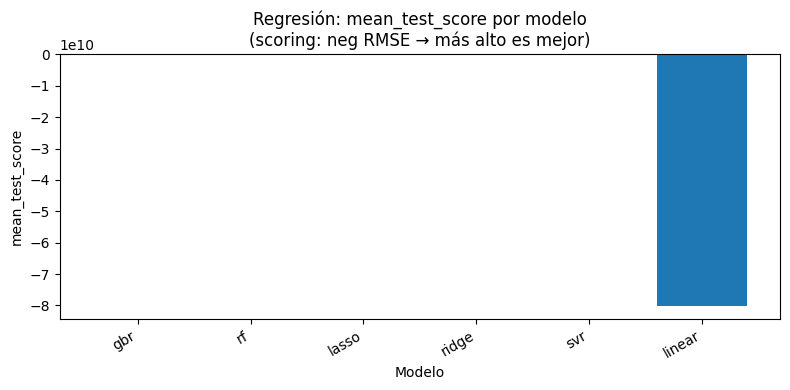

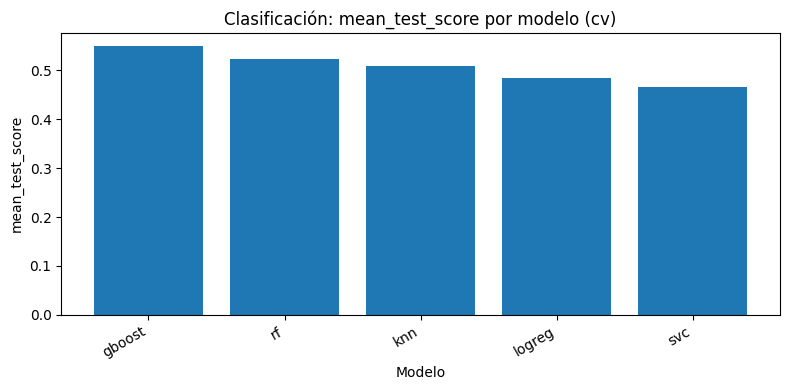

In [10]:

# Regresión
if not reg_model_summary.empty:
    plt.figure(figsize=(8,4))
    plt.bar(reg_model_summary["model_name"], reg_model_summary["mean_score"])
    plt.title("Regresión: mean_test_score por modelo\n(scoring: neg RMSE → más alto es mejor)")
    plt.xlabel("Modelo"); plt.ylabel("mean_test_score")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()

# Clasificación
if not clf_model_summary.empty:
    plt.figure(figsize=(8,4))
    plt.bar(clf_model_summary["model_name"], clf_model_summary["mean_score"])
    plt.title("Clasificación: mean_test_score por modelo (cv)")
    plt.xlabel("Modelo"); plt.ylabel("mean_test_score")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()


In [11]:

def best_cv_row(cv_df: pd.DataFrame):
    if cv_df.empty: return None
    return cv_df.sort_values(["rank_test_score","mean_test_score"], ascending=[True, False]).head(1)

best_reg = best_cv_row(reg_cv)
best_clf = best_cv_row(clf_cv)

print("Mejor modelo REGRESIÓN (CV):")
display(best_reg if best_reg is not None else "sin datos")
print("Metrics finales (test) REG:", reg_metrics)

print("\nMejor modelo CLASIFICACIÓN (CV):")
display(best_clf if best_clf is not None else "sin datos")
print("Metrics finales (test) CLF:", clf_metrics)


Mejor modelo REGRESIÓN (CV):


,model_name,params,mean_test_score,std_test_score,rank_test_score
5,gbr,"{'model__learning_rate': 0.1, 'model__n_estima...",-31.397396,5.550301,1


Metrics finales (test) REG: {'MAE': 13.178404038913769, 'RMSE': 29.748183154958575, 'R2': 0.8909658508578912}

Mejor modelo CLASIFICACIÓN (CV):


,model_name,params,mean_test_score,std_test_score,rank_test_score
4,gboost,"{'model__learning_rate': 0.1, 'model__n_estima...",0.559489,0.024988,1


Metrics finales (test) CLF: {'accuracy': 0.837696335078534, 'precision': 0.4117647058823529, 'recall': 0.11864406779661017, 'f1_macro': 0.547047123623011, 'roc_auc': 0.6902319357716324}


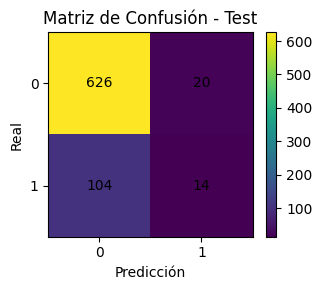

In [12]:

if clf_conf is not None:
    cm = np.array(clf_conf)
    plt.figure(figsize=(4,3))
    im = plt.imshow(cm, interpolation='nearest')
    plt.title("Matriz de Confusión - Test")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    tick_marks = np.arange(cm.shape[0])
    plt.xticks(tick_marks, tick_marks); plt.yticks(tick_marks, tick_marks)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(int(cm[i, j])), ha="center", va="center")
    plt.ylabel("Real"); plt.xlabel("Predicción")
    plt.tight_layout()
    plt.show()
else:
    print("No se encontró clf_confusion_matrix.json")


In [13]:

def explain_reg(metrics: dict):
    if not metrics: return "Regresión: no hay métricas."
    r2 = metrics.get("R2"); rmse = metrics.get("RMSE"); mae = metrics.get("MAE")
    msg = [f"Regresión:",
           f"- R2 = {r2:.3f} (↑ mejor)" if r2 is not None else "- R2 = n/a",
           f"- RMSE = {rmse:.3f} (↓ mejor)" if rmse is not None else "- RMSE = n/a",
           f"- MAE = {mae:.3f} (↓ mejor)" if mae is not None else "- MAE = n/a"]
    return "\n".join(msg)

def explain_clf(metrics: dict):
    if not metrics: return "Clasificación: no hay métricas."
    parts = []
    def f(key, label):
        v = metrics.get(key)
        parts.append(f"- {label} = {v:.3f}" if isinstance(v,(int,float)) and v is not None else f"- {label} = n/a")
    parts.append("Clasificación:")
    f("accuracy","Accuracy")
    f("f1_macro","F1 (macro)")
    f("precision_macro","Precision (macro)")
    f("recall_macro","Recall (macro)")
    f("roc_auc","ROC-AUC")
    return "\n".join(parts)

print(explain_reg(reg_metrics)); print(); print(explain_clf(clf_metrics))


Regresión:
- R2 = 0.891 (↑ mejor)
- RMSE = 29.748 (↓ mejor)
- MAE = 13.178 (↓ mejor)

Clasificación:
- Accuracy = 0.838
- F1 (macro) = 0.547
- Precision (macro) = n/a
- Recall (macro) = n/a
- ROC-AUC = 0.690
